In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [18]:
def preprocess_df(df): 
    item_key = 'reference'
    session_key = 'session_id'
    time_key = 'timestamp'
    
    n_items = len(train_data[item_key].unique())
    aux = list(train_data[item_key].unique())
    itemids = np.array(aux)
    itemidmap = pd.Series(data=np.arange(n_items), index=itemids)  # (id_item => (0, n_items))
    
    data = pd.merge(df, pd.DataFrame({item_key:itemids, 'ItemIdx':itemidmap[itemids].values}), on=item_key, how='inner')
    data.sort_values([session_key, time_key], inplace=True)

    length = len(data[item_key])
        
    return data

In [29]:
def compute_dwell_time(df):
   
    times_t = np.roll(df['timestamp'], -1) # Take time row
    times_dt  = df['timestamp']            # Copy, then displace by one
    
    diffs = np.subtract(times_t, times_dt) # Take the pairwise difference
    
    length = len(df['reference'])
    
    # cummulative offset start for each session
    offset_sessions = np.zeros(df['session_id'].nunique()+1, dtype=np.int32)
    offset_sessions[1:] = df.groupby('session_id').size().cumsum() 
    
    offset_sessions = offset_sessions - 1
    offset_sessions = np.roll(offset_sessions, -1)
    
    # session transition implies zero-dwell-time
    # note: paper statistics do not consider null entries, 
    # though they are still checked when augmenting
    np.put(diffs, offset_sessions, np.zeros((offset_sessions.shape)), mode='raise')
        
    return diffs

# get paper statistics
def get_statistics(dts):
    filtered = np.array(list(filter(lambda x: int(x) != 0, dts)))
    pd_dts = pd.DataFrame(filtered)
    pd_dts.boxplot(vert=False, showfliers=False) # no outliers in boxplot
    plt.show()
    pd_dts.describe()

def join_dwell_reps(df, dt, threshold=2000):
    # Calculate d_ti/threshold + 1
    # then add column to dataFrame
    
    dt //= threshold
    dt += 1   
    df['DwellReps'] = pd.Series(dt.astype(np.int64), index=dt.index)
    #return df

def augment(df):    
    col_names = list(df.columns.values)[:3]
    print(col_names)
    augmented = np.repeat(df.values, df['DwellReps'], axis=0) 
    print(augmented[0][:3])  
    augmented = pd.DataFrame(data=augmented[:,:3],
                             columns=col_names)
    
    dtype = {
             'reference': np.int64, 
             'timestamp': np.float32}
    
    for k, v in dtype.items():
        augmented[k] = augmented[k].astype(v)
                             
    
    return augmented

In [16]:
PATH_TO_TRAIN = '~/SecretGarden/DeepLearning/RecSy/trivagodataset/train_drop_duplicates_and_after_last_clickout_items.csv'
train_data = pd.read_csv(PATH_TO_TRAIN, sep=',')
train_data.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037542,9,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


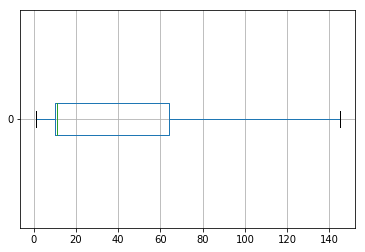

In [20]:
train_data=train_data[train_data["reference"].str.isnumeric()]
new_df = preprocess_df(train_data)
dts = compute_dwell_time(new_df)

get_statistics(dts)

join_dwell_reps(new_df, dts, threshold=200000)

In [23]:
new_df

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,ItemIdx,DwellReps
2856892,WT30CXPIG450,00000510f1adc,1541064087,1,clickout item,7281198,IN,"Ganpatipule, India",desktop,NaN,2661832|9222426|7051844|4079190|5752778|468398...,46|26|16|38|12|20|21|27|13|21|36|9|144|19|8|19...,108184,1
3560258,CITFOTN2IT5P,00003f3b20954,1541097696,1,clickout item,979325,ES,"La Manga, Spain",mobile,NaN,87132|886881|486611|979325|87173|87175|149508|...,330|187|437|159|499|324|476|381|424|159|144|19...,212183,1
389144,0TBXPQCK401O,000056cd97ce2,1541483846,1,search for item,2784325,MY,"Port Dickson, Malaysia",desktop,NaN,NaN,NaN,5582,1
1046543,0TBXPQCK401O,000056cd97ce2,1541483874,2,search for item,3811810,MY,"Port Dickson, Malaysia",desktop,NaN,NaN,NaN,18692,1
1046544,0TBXPQCK401O,000056cd97ce2,1541483924,3,clickout item,3811810,MY,"Port Dickson, Malaysia",desktop,NaN,3811810|496141|674016|1153426|1339848|8400372|...,187|78|100|51|150|81|44|36|53|104|93|48|38|52|...,18692,1
1046545,0TBXPQCK401O,000056cd97ce2,1541484101,4,clickout item,3811810,MY,"Port Dickson, Malaysia",desktop,NaN,3811810|496141|674016|1153426|1339848|8400372|...,187|78|100|51|150|81|44|36|53|104|93|48|38|52|...,18692,1
3624299,XRIOQ0R1CHLT,000066611146f,1541332330,3,clickout item,5479306,BE,"Obaköy, Turkey",desktop,Hotel|Resort,5479306|97126|2195126|4163966|8415348|7829686|...,96|81|87|122|50|21|90|177|81|144|122|44|66|121...,228195,1
3091481,X931R6LTG2RE,0000be39860d7,1541102752,1,interaction item image,445081,US,"Chattanooga, USA",desktop,NaN,NaN,NaN,132866,1
3091482,X931R6LTG2RE,0000be39860d7,1541102762,3,interaction item image,445081,US,"Chattanooga, USA",desktop,NaN,NaN,NaN,132866,1
3091483,X931R6LTG2RE,0000be39860d7,1541102772,8,interaction item image,445081,US,"Chattanooga, USA",desktop,NaN,NaN,NaN,132866,1


In [30]:
# Now, we augment the sessions copying each entry an additional (dwellReps[i]-1) times
df_aug = augment(new_df)
df_aug.head()

['user_id', 'session_id', 'timestamp']
['WT30CXPIG450' '00000510f1adc' 1541064087]


KeyError: 'reference'